In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns

from matplotlib import rcParams

LoadDatas
-----
- excel data structure
    - column.row
    - col.0 : B1
    - col.1 : B1_1_동
    - col.2 : B1_1_호수
    - col.3:end : timeslot

In [2]:
xlsx = pd.read_excel('datas.xlsx', 
                    header = None, 
                    skiprows = 2,
                    engine = 'openpyxl')

data_startcol = 7
ogDatasObj = {}
for col in xlsx:
    if col >= data_startcol: # startcol 7
        ogDatasObj[f'{xlsx[col][0]}-{xlsx[col][1]}-{xlsx[col][2]}'] = xlsx[col][3:]

ogDatas = pd.DataFrame(ogDatasObj)
ogDatas = ogDatas.fillna(0)
ogDatas = ogDatas.reset_index()
del ogDatas['index']

pd.set_option('display.max_row', 20)
pd.set_option('display.max_columns', 100)

ogDatas

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,아파트1-103-502,아파트1-103-1602,아파트1-103-301,아파트1-103-1502,아파트1-103-202,아파트1-102-903,아파트1-102-603,아파트1-102-203,아파트1-102-704,아파트1-102-703,아파트1-102-403,아파트1-102-303,아파트1-101-604,아파트1-101-1602,아파트1-101-1002,아파트1-101-1202,아파트1-101-1604,아파트1-101-402,아파트1-101-303,아파트1-101-502,아파트1-101-1403,아파트1-101-904,아파트1-101-1502,아파트1-101-1102,아파트1-101-901,아파트1-101-704,아파트1-101-504,아파트1-102-104,아파트1-102-301,아파트1-102-1501,아파트1-102-1602,아파트1-102-1002,아파트1-102-401,아파트1-102-802,아파트1-102-801,아파트1-103-505,아파트1-103-1805,아파트1-103-1306,아파트1-103-1806,아파트1-103-803,...,아파트4-103-609,아파트4-103-707,아파트4-103-101,아파트4-102-803,아파트4-101-1501,아파트4-103-404,아파트4-103-909,아파트4-101-1203,아파트4-103-806,아파트4-103-1410,아파트4-103-402,아파트4-103-703,아파트4-103-106,아파트4-103-910,아파트4-102-402,아파트4-103-907,아파트4-103-1406,아파트4-103-1006,아파트4-103-608,아파트4-103-403,아파트4-105-1102,아파트4-103-804,아파트4-103-103,아파트4-103-706,아파트4-104-1001,아파트4-105-103,아파트4-102-401,아파트4-103-1104,아파트4-103-906,아파트4-103-606,아파트4-103-1307,아파트4-103-410,아파트4-103-1309,아파트4-102-102,아파트4-103-508,아파트4-105-1104,아파트4-102-1402,아파트4-103-407,아파트4-103-1206,아파트4-103-108,아파트4-105-102,아파트4-103-1102,아파트4-105-601,아파트4-104-1501,아파트4-103-702,아파트4-102-104,아파트4-103-902,아파트4-101-602,아파트4-103-905,아파트4-101-104
0,0.085,0.016,0.052,0.003,0.032,0.074,0.053,0.096,0.105,0.042,0.149,0.039,0.054,0.132,0.091,0.169,0.051,0.118,0.060,0.047,0.047,0.053,0.046,0.104,0.079,0.092,0.043,0.069,0.139,0.026,0.146,0.092,0.025,0.127,0.045,0.042,0.113,0.207,0.030,0.171,0.045,0.064,0.045,0.277,0.186,0.142,0.132,0.034,0.088,0.041,...,0.041,0.137,0.114,0.046,0.098,0.058,0.068,0.040,0.063,0.048,0.168,0.053,0.099,0.075,0.080,0.158,0.024,0.153,0.056,0.037,0.091,0.069,0.128,0.092,0.072,0.069,0.034,0.166,0.086,0.113,0.184,0.175,0.096,0.054,0.080,0.084,0.119,0.088,0.117,0.161,0.182,0.044,0.051,0.057,0.126,0.094,0.065,0.116,0.093,0.147
1,0.086,0.049,0.053,0.002,0.022,0.014,0.048,0.090,0.108,0.022,0.119,0.023,0.075,0.142,0.063,0.183,0.045,0.164,0.065,0.066,0.043,0.056,0.045,0.130,0.081,0.102,0.042,0.083,0.176,0.046,0.113,0.088,0.026,0.116,0.066,0.050,0.139,0.188,0.031,0.165,0.032,0.068,0.052,0.244,0.209,0.205,0.161,0.039,0.094,0.036,...,0.036,0.083,0.124,0.055,0.115,0.068,0.072,0.032,0.085,0.111,0.173,0.050,0.103,0.068,0.076,0.360,0.031,0.132,0.038,0.037,0.097,0.075,0.123,0.072,0.053,0.059,0.023,0.135,0.143,0.112,0.101,0.163,0.154,0.078,0.036,0.076,0.092,0.042,0.121,0.179,0.117,0.060,0.036,0.055,0.116,0.089,0.083,0.113,0.105,0.130
2,0.085,0.013,0.073,0.002,0.016,0.051,0.029,0.033,0.097,0.046,0.116,0.018,0.071,0.096,0.159,0.122,0.043,0.141,0.097,0.064,0.055,0.054,0.051,0.119,0.109,0.097,0.056,0.086,0.126,0.036,0.113,0.079,0.027,0.170,0.072,0.044,0.163,0.201,0.053,0.163,0.041,0.071,0.046,0.256,0.173,0.199,0.122,0.028,0.084,0.026,...,0.045,0.081,0.115,0.063,0.070,0.053,0.078,0.036,0.083,0.111,0.084,0.053,0.084,0.071,0.087,0.471,0.024,0.079,0.047,0.036,0.078,0.059,0.137,0.084,0.083,0.056,0.036,0.106,0.160,0.108,0.184,0.162,0.124,0.135,0.053,0.073,0.108,0.056,0.100,0.224,0.147,0.053,0.075,0.032,0.131,0.055,0.084,0.153,0.119,0.104
3,0.085,0.043,0.067,0.002,0.015,0.015,0.031,0.092,0.048,0.067,0.102,0.031,0.128,0.082,0.104,0.141,0.031,0.103,0.075,0.082,0.046,0.016,0.046,0.078,0.070,0.073,0.051,0.085,0.098,0.048,0.145,0.078,0.021,0.142,0.062,0.034,0.149,0.194,0.038,0.065,0.043,0.070,0.043,0.274,0.047,0.108,0.162,0.034,0.069,0.038,...,0.039,0.086,0.068,0.035,0.064,0.061,0.065,0.022,0.066,0.087,0.080,0.047,0.079,0.066,0.029,0.187,0.030,0.059,0.055,0.035,0.080,0.074,0.090,0.066,0.071,0.062,0.034,0.114,0.121,0.108,0.051,0.170,0.068,0.072,0.074,0.078,0.101,0.080,0.084,0.178,0.152,0.047,0.064,0.022,0.104,0.057,0.087,0.149,0.102,0.093
4,0.084,0.033,0.051,0.003,0.022,0.052,0.052,0.030,0.041,0.045,0.102,0.032,0.122,0.069,0.089,0.103,0.011,0.094,0.084,0.053,0.047,0.022,0.048,0.040,0.077,0.089,0.041,0.092,0.062,0.045,0.109,0.109,0.033,0.084,0.069,0.035,0.225,0.199,0.078,

SetDatas
---
## 특정 가구를 날짜별로 나누는 작업
- timeslotDatas === tsDatas

In [138]:
startDate = datetime(2018,5,1)
endDate = datetime(2019,5,1)
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
dateIndexArr = [dt.strftime('%Y%m%d') for dt in
                   datetime_range(startDate, endDate, timedelta(days = 1))]

searchKeyword = '아파트1-104-1206'
tsDatasObj = {}
startIdx = 0;
endIdx = 96;
for date in dateIndexArr:
    tsDatasObj[date] = ogDatas[searchKeyword][startIdx:endIdx].values.tolist()
    startIdx = endIdx
    endIdx = endIdx + 96

tsDatas = pd.DataFrame(tsDatasObj)
tsDatas = tsDatas.T
tsDatas = tsDatas.reset_index()
tsDatas.rename(columns={'index':'date'}, inplace=True)
tsDatas['year'] = [dt[0:4] for dt in tsDatas['date']]
tsDatas['month'] = [dt[4:6] for dt in tsDatas['date']]
tsDatas['day'] = [dt[6:8] for dt in tsDatas['date']]
tsDatas['date'] = [datetime.strptime(dt, "%Y%m%d") for dt in tsDatas['date']]
tsDatas.reindex(columns=['date', 'year', 'month', 'day'])

,date,year,month,day
0,2018-05-01,2018,05,01
1,2018-05-02,2018,05,02
2,2018-05-03,2018,05,03
3,2018-05-04,2018,05,04
4,2018-05-05,2018,05,05
...,...,...,...,...
360,2019-04-26,2019,04,26
361,2019-04-27,2019,04,27
362,2019-04-28,2019,04,28
363,2019-04-29,2019,04,29


Select Season, Day
---
## 해당 가구의 데이터 중에서 계절, 날짜에 맞게 변환

In [139]:
DAYS = {
    "월" : 0,
    "화" : 1,
    "수" : 2,
    "목" : 3,
    "금" : 4,
    "토" : 5,
    "일" : 6
}

SEASONS = {
    "봄" : ["03", "04", "05"],
    "여름" : ["06", "07", "08"],
    "가을" : ["09", "10", "11"],
    "겨울" : ["12", "01", "02"]
}

ALLDATAS = False
DAY = "월"
SEASON = "봄"
# ALLDATAS is tsDatas
if ALLDATAS:
    datas = tsDatas
else :    
    datas = tsDatas[(tsDatas['month'].isin(SEASONS[SEASON]))
            & (tsDatas['date'].dt.weekday == DAYS[DAY]) ]
datas

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,year,month,day
6,2018-05-07,0.100,0.117,0.078,0.052,0.051,0.032,0.044,0.051,0.050,0.043,0.030,0.050,0.051,0.050,0.034,0.041,0.051,0.050,0.047,0.030,0.046,0.050,0.050,0.036,0.036,0.051,0.050,0.043,0.030,0.053,0.056,0.093,0.052,0.058,0.056,0.055,0.055,0.054,0.054,0.054,0.053,0.053,0.053,0.054,0.053,0.053,0.052,0.054,0.053,0.053,0.052,0.053,0.046,0.032,0.054,0.052,0.053,0.052,0.032,0.046,0.053,0.053,0.052,0.034,0.045,0.054,0.052,0.052,0.033,0.047,0.054,0.053,0.053,0.034,0.046,0.053,0.053,0.052,0.039,0.040,0.053,0.053,0.052,0.041,0.076,0.119,0.084,0.084,0.070,0.071,0.086,0.090,0.090,0.084,0.081,0.088,2018,05,07
13,2018-05-14,0.113,0.076,0.056,0.059,0.059,0.047,0.055,0.057,0.056,0.054,0.054,0.054,0.054,0.053,0.053,0.053,0.053,0.052,0.053,0.052,0.052,0.054,0.052,0.052,0.052,0.051,0.052,0.051,0.051,0.051,0.058,0.092,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.050,0.043,0.030,0.049,0.051,0.050,0.043,0.029,0.049,0.051,0.051,0.038,0.032,0.050,0.050,0.048,0.030,0.044,0.051,0.050,0.037,0.034,0.056,0.056,0.053,0.043,0.054,0.053,0.052,0.052,0.052,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.118,0.089,0.064,0.062,0.061,0.060,0.059,0.057,0.054,0.053,0.050,0.050,0.050,0.046,0.029,0.046,0.050,0.050,0.041,2018,05,14
20,2018-05-21,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.056,0.055,0.056,0.056,0.055,0.054,0.055,0.055,0.054,0.055,0.055,0.055,0.054,0.051,0.035,0.055,0.055,0.055,0.053,0.040,0.043,0.055,0.054,0.055,0.046,0.037,0.055,0.055,0.055,0.038,0.045,0.062,0.087,0.133,0.070,0.073,0.086,0.084,0.080,0.063,0.082,0.085,0.084,2018,05,21
27,2018-05-28,0.054,0.054,0.054,0.054,0.054,0.080,0.067,0.053,0.055,0.054,0.055,0.054,0.054,0.053,0.053,0.043,0.039,0.053,0.054,0.053,0.052,0.033,0.048,0.054,0.053,0.053,0.036,0.044,0.054,0.053,0.053,0.076,0.043,0.050,0.051,0.050,0.031,0.045,0.050,0.050,0.051,0.032,0.044,0.051,0.050,0.050,0.043,0.033,0.051,0.052,0.058,0.056,0.043,0.053,0.054,0.052,0.052,0.051,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.050,0.050,0.051,0.050,0.050,0.051,0.050,0.050,0.050,0.050,0.051,0.084,0.097,0.093,0.096,0.071,0.062,0.061,0.052,0.041,0.058,2018,05,28
307,2019-03-04,0.029,0.021,0.021,0.021,0.035,0.037,0.021,0.020,0.021,0.028,0.037,0.028,0.020,0.022,0.020,0.037,0.034,0.021,0.021,0.021,0.028,0.038,0.025,0.021,0.051,0.033,0.037,0.033,0.021,0.021,0.021,0.029,0.037,0.025,0.021,0.021,0.021,0.038,0.032,0.021,0.021,0.021,0.030,0.037,0.024,0.021,0.021,0.021,0.038,0.031,0.021,0.021,0.020,0.032,0.037,0.024,0.021,0.021,0.021,0.040,0.031,0.021,0.021,0.021,0.031,0.037,0.023,0.021,0.021,0.024,0.038,0.030,0.021,0.021,0.022,0.032,0.038,0.021,0.021,0.028,0.076,0.092,0.081,0.075,0.062,0.061,0.072,0.076,0.061,0.060,0.061,0.065,0.073,0.029,0.022,0.022,2019,03,04
314,2019-03-11,0.013,0.013,0.013,0.029,0.037,0.016,0.012,0.013,0.026,0.031,0.023,0.013,0.012,0.021,0.028,0.029,0.016,0.021,0.012,0.018,0.030,0.030,0.016,0.013,0.033,0.037,0.029,0.018,0.013,0.013,0.013,0.031,0.027,0.013,0.012,0.013,0.021,0.029,0.021,0.013,0.013,0.012,0.028,0.029,0.014,0.013,0.013,0.016,0.030,0.024,0.013,0.012,0.013,0.023,0.029,0.018,0.012,0.013,0.013,0.028,0.028,0.013,0.013,0.012,0.017,0.030,0.022,0.013,0.012,0.013,0.022,0.029,0.017,0.013,0.013,0.012,0.026,0.029,0.026,0.064,0.053,0.048,0.064,0.062,0.056,0.046,0.046,0.052,0.070,0.061,0.036,0.013,0.016,0.025,0.029,0.020,2019,03,11
321,2019-03-18,0.050,0.041,0.040,0.009,0.041,0.043,0.027,0.026,0.026,0.033,0.025,0.019,0.007,0

DataPreprocessing
---
- 데이터 전처리
    - StandardScaler : 각 특성의 평균을 0, 분산을 1로 변경하여 특성의
        스케일을 맞춘다.

In [149]:
dpp = datas[datas.columns.difference(['date', 'year', 'month', 'day'])]
dpp = dpp

scaler = StandardScaler()
# scaler = RobustScaler()
dpp = pd.DataFrame(scaler.fit_transform(dpp))

dpp.index = datas['date']
dpp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-07,1.856783,2.630712,2.208264,1.244011,1.004749,-0.007843,0.829315,1.314867,1.242827,0.769627,0.033124,1.177234,1.352854,1.331413,0.394780,0.756024,1.317396,1.229840e+00,1.178889,0.255,1.130727,1.385470,1.242069,0.425671,0.300737,1.240522,1.377136,0.901388,0.004902,1.430193,1.508284,1.886327,1.467970,1.719184,1.495671,1.582832,1.856225,1.534937,1.530853,1.540140,1.449581,2.098214,1.610066,1.450745,1.533566,1.557711,1.717240,1.842755,1.418689,1.458838,1.514451,1.534383,1.153754,0.269966,1.416992,1.612131,1.534097,1.296178,0.293936,1.142245,1.598383,1.423361,1.345955,0.330503,1.089383,1.387246,1.479550,1.655248,0.386170,1.060944,1.402189,1.451571,1.691545,0.440373,0.700973,0.893772,0.081280,0.023986,-0.423469,-0.596726,-0.192303,-0.116823,-0.169217,-0.785366,1.129233,2.371944,0.632203,1.042783,0.262553,0.099445,0.930818,1.228459,1.603510,1.548515,1.422714,1.800495
2018-05-14,2.256524,1.314121,1.143233,1.664848,1.488517,0.756880,1.388712,1.661353,1.632146,1.498480,1.509528,1.403960,1.517219,1.531896,1.712493,1.502478,1.441499,1.352824e+00,1.539490,1.685,1.489250,1.644623,1.372813,1.467313,1.326202,1.240522,1.501894,1.416467,1.343202,1.312890,1.615138,1.853099,1.407770,1.319067,1.216307,1.346317,1.591050,1.298793,1.360272,1.309341,0.867959,0.315924,1.343431,1.288628,1.364135,0.963862,0.087225,1.493545,1.301591,1.349214,0.729180,0.253384,1.422790,1.439820,1.089024,0.316992,1.018323,1.237054,1.459718,0.575962,0.463899,1.584263,1.571002,1.513609,0.962937,1.387246,1.537484,1.655248,1.563750,1.355650,1.229134,1.278448,1.559075,1.458124,0.967424,0.731646,0.015240,2.596471,1.929135,0.782374,0.319048,0.333162,0.282028,0.138130,-0.067851,-0.265283,-0.520638,-0.639371,-0.590745,-0.776311,-0.755681,-1.021352,-0.439269,0.024142,0.122592,0.017509
2018-05-21,0.380818,0.543434,0.949591,1.244011,1.065220,1.011788,1.236149,1.372615,1.372600,1.365961,1.386494,1.290597,1.407642,1.465068,1.643140,1.440274,1.379447,1.352824e+00,1.479390,1.685,1.489250,1.515046,1.372813,1.467313,1.326202,1.307438,1.501894,1.480851,1.406930,1.371542,1.294576,0.523980,1.467970,1.376226,1.272180,1.405446,1.657344,1.416865,1.417132,1.424740,1.391419,2.020723,1.543407,1.342667,1.477089,1.498326,1.717240,1.703071,1.360140,1.404026,1.514451,1.473383,1.557309,1.829771,1.471654,1.847611,1.706022,1.473550,1.718781,1.708527,1.717803,1.476995,1.514740,1.638146,1.721614,1.387246,1.421616,0.588747,1.749683,1.532474,1.459874,1.451571,0.830488,1.012858,1.180586,0.947814,0.147319,-0.209876,-0.517573,0.265212,-0.078669,-0.004327,-0.958896,-0.580145,0.247171,1.073617,2.454436,0.350131,0.390548,0.724985,0.846493,0.859638,0.349987,1.458846,1.590472,1.648752
2018-05-28,0.442317,0.607658,1.046412,1.364250,1.186162,2.439272,1.998963,1.430363,1.567260,1.498480,1.571044,1.403960,1.517219,1.531896,1.712493,0.880433,0.572781,1.414316e+00,1.599591,1.750,1.489250,0.284071,1.111325,1.597518,1.390293,1.374355,0.503830,0.965773,1.534387,1.430193,1.348003,1.321451,0.926164,1.261907,1.216307,1.287188,0.265175,1.003613,1.303412,1.309341,1.333257,0.470906,1.010137,1.288628,1.364135,1.379556,1.079408,0.376072,1.301591,1.404026,1.850996,1.717383,0.951976,1.634796,1.416992,1.612131,1.476789,1.237054,1.524484,1.456846,1.478964,1.316094,1.289693,1.326802,1.468722,1.218175,1.363682,1.592513,1.501772,1.237768,1.229134,1.336156,1.492840,1.521733,0.967424,0.731646,-0.017780,-0.014991,0.094104,-0.022101,-0.305937,-0.285567,-0.282028,-0.323618,-0.508882,-0.387001,0.632203,1.685959,1.243847,1.142012,0.298381,0.195759,0.257133,0.113811,-0.254863,0.662419
2019-03-04,-0.326415,-0.452038,-0.551135,-0.619693,0.037213,0.247065,-0.340332,-0.47

Dimensionality Reduction
---
- 차원축소
    - PCA : Principal component analysis, 주성분 분석

In [150]:
pca = PCA(n_components=2)

pca.fit(dpp)
dr = pd.DataFrame(pca.transform(dpp), columns = ['x','y'])

dr.index = datas['date']
dr

,x,y
date,,
2018-05-07,11.459121,-0.699216
2018-05-14,11.084191,2.470812
2018-05-21,12.645530,0.007833
2018-05-28,11.223524,0.934446
2019-03-04,-1.231560,-0.164550
2019-03-11,-5.287013,2.301037
2019-03-18,-5.734383,0.711375
2019-03-25,-2.694101,-6.699826
2019-04-01,-8.150084,-2.647204


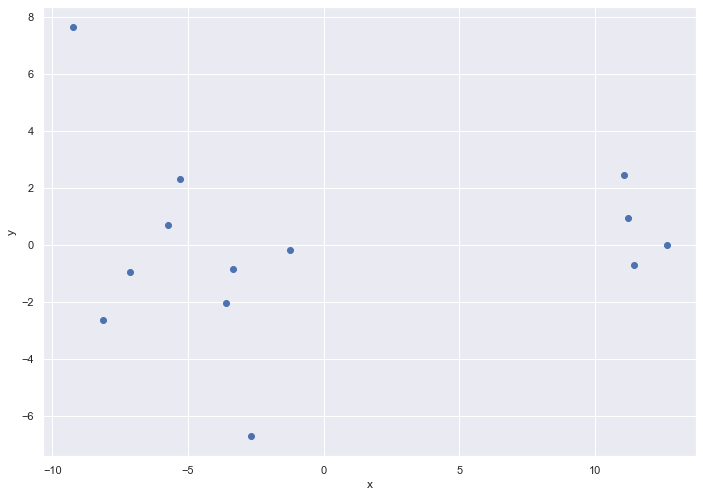

In [151]:
plt.scatter(dr['x'], dr['y'], marker = 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [152]:
K = 3

points = dr.values
kmeans = KMeans(n_clusters=K).fit(points)
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['x', 'y'])

clusterNum = [i for i in range(K)]
centers['cluster'] = [i for i in range(len(centers))]
centers['type'] = [f'cluster' for dt in clusterNum]
centers

,x,y,cluster,type
0,11.603091,0.678469,0,cluster
1,-4.646659,-1.294576,1,cluster
2,-9.239093,7.642732,2,cluster


In [153]:
kmeans.labels_

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [154]:
clustering = dr
clustering['cluster'] = kmeans.labels_
clustering['type'] = ['data' for i in range(len(clustering['x']))]

result = pd.concat([clustering, centers], axis = 0)

result

,x,y,cluster,type
2018-05-07 00:00:00,11.459121,-0.699216,0,data
2018-05-14 00:00:00,11.084191,2.470812,0,data
2018-05-21 00:00:00,12.645530,0.007833,0,data
2018-05-28 00:00:00,11.223524,0.934446,0,data
2019-03-04 00:00:00,-1.231560,-0.164550,1,data
2019-03-11 00:00:00,-5.287013,2.301037,1,data
2019-03-18 00:00:00,-5.734383,0.711375,1,data
2019-03-25 00:00:00,-2.694101,-6.699826,1,data
2019-04-01 00:00:00,-8.150084,-2.647204,1,data
2019-04-08 00:00:00,-3.590298,-2.054368,1,data


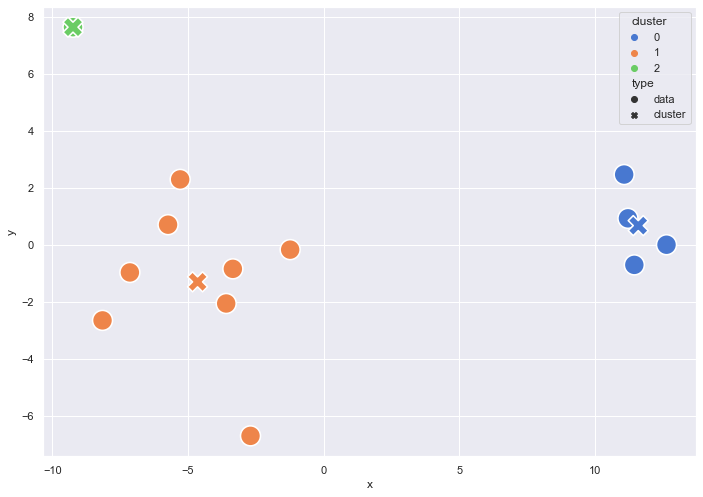

In [155]:
sns.scatterplot(x='x', y="y", 
                hue="cluster", 
                style="type",
                palette="muted",
                s=400,
                data=result)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
rcParams['figure.figsize'] = 11.7,8.27
plt.title = "클러스터링 결과물"
plt.show()

1안 : 일반 적인 그룹핑 데이터
---

<AxesSubplot:>

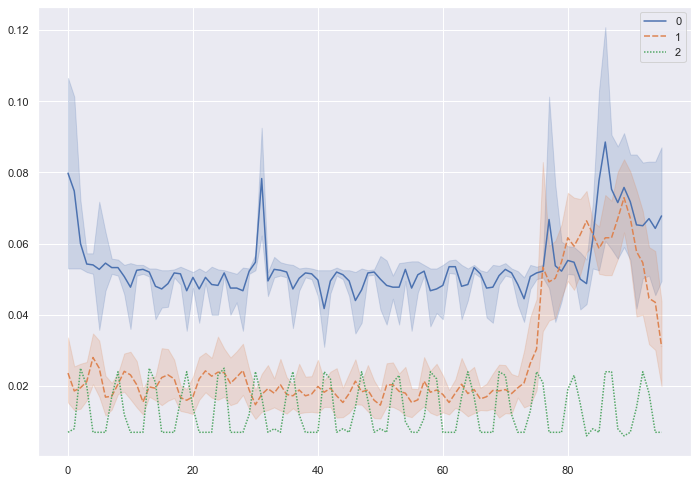

In [156]:
tsCheck = datas[datas.columns.difference(['year', 'month', 'day'])]
tsCheck.reset_index(inplace=True)
del tsCheck['index']
tsCheck = tsCheck.set_index('date')
tsCheck['cluster'] = clustering['cluster']
tsCheck.reset_index(inplace=True)
tsCheck.set_index(['cluster', 'date'], inplace=True)
tsCheck = tsCheck.T
tsCheck
sns.lineplot(data=tsCheck)

2안 : 데이터 전처리 데이터
---

<AxesSubplot:>

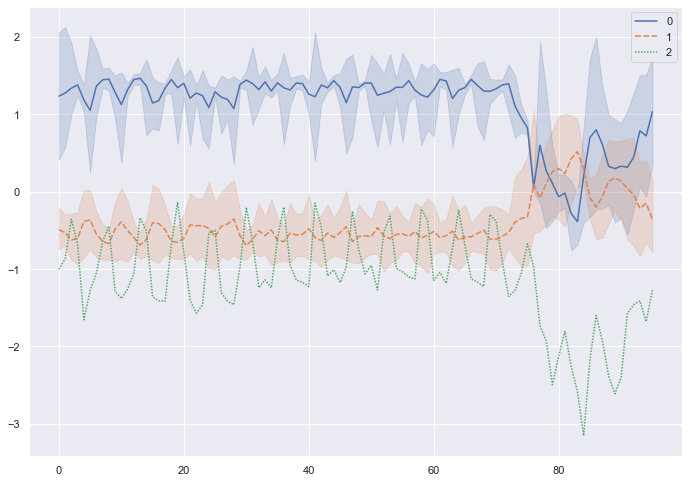

In [157]:
dppCheck = dpp
dppCheck['cluster'] = clustering['cluster']
dppCheck.reset_index(inplace=True)
dppCheck.set_index(['cluster', 'date'], inplace=True)
dppCheck = dppCheck.T
dppCheck
sns.lineplot(data=dppCheck)

In [158]:
'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
processingData = [];
for d in tsCheck:
    for idx,t in enumerate(tsCheck[d]):
        processingData.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t
        })
processingData = pd.DataFrame(processingData)
processingData

,date,timeslot,cluster,data
0,2018-05-07,0,cluster-0,0.100
1,2018-05-07,1,cluster-0,0.117
2,2018-05-07,2,cluster-0,0.078
3,2018-05-07,3,cluster-0,0.052
4,2018-05-07,4,cluster-0,0.051
...,...,...,...,...
1243,2019-04-29,91,cluster-1,0.047
1244,2019-04-29,92,cluster-1,0.046
1245,2019-04-29,93,cluster-1,0.049
1246,2019-04-29,94,cluster-1,0.055


<AxesSubplot:xlabel='timeslot', ylabel='data'>

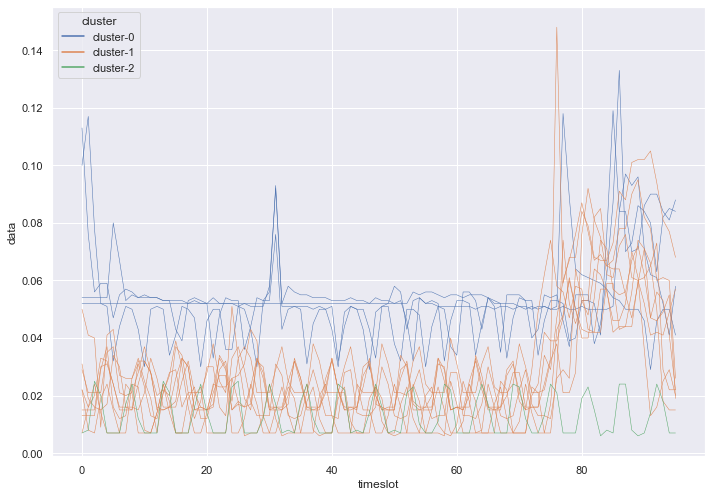

In [159]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            units="date",
            hue="cluster",
            estimator=None,
            lw=0.5)

<AxesSubplot:xlabel='timeslot', ylabel='data'>

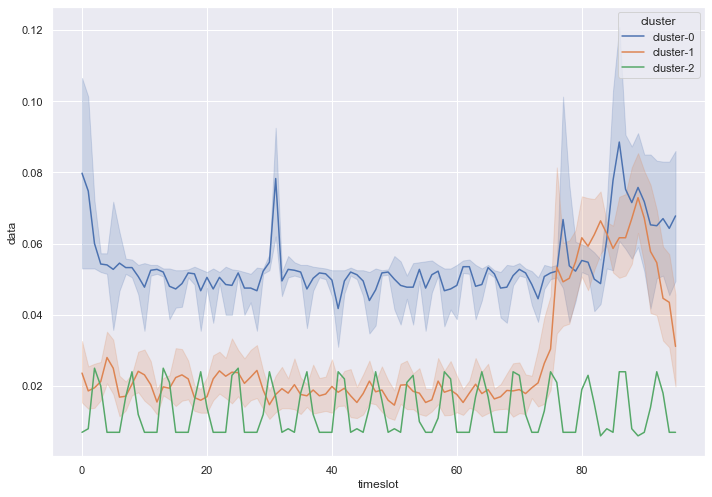

In [160]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            hue="cluster",)